# JUICE Flybys of Jovian Moons
## Objectives
 
This examples shows how to use **TUDAT functionalities** to:
1) retrieve **JUICE's position with respect to a given flyby moon** from their SPICE ephemerides, at a given time;
2) propagate from the **midpoint of an arc** (both backwards and forwards);
3) propagate using a **variable time step**


## Import Statements
To start off, we import all the relevant modules.

In [1]:
import sys
# Load required standard modules
import os
import numpy as np
from matplotlib import pyplot as plt

# Load required tudatpy modules
from tudatpy import constants
from tudatpy.interface import spice
from tudatpy import numerical_simulation
from tudatpy.numerical_simulation import environment
from tudatpy.numerical_simulation import environment_setup
from tudatpy.numerical_simulation import propagation, propagation_setup
from tudatpy.numerical_simulation import estimation, estimation_setup
from tudatpy.numerical_simulation.estimation_setup import observation
from tudatpy.astro.time_conversion import DateTime
from tudatpy.astro import element_conversion
from tudatpy.util import result2array

# Auxiliary Functions
We define **two auxiliary functions** to be used throughout the code:
1) `get_juice_position_wrt_moon`

   This function takes a time instant as input, and gives the **cartesian position of JUICE (body -28) with respect to the flyby moon**, in the J2000 reference frame as output. It is just a call to the [`spice.get_body_cartesian_position_at_epoch`](https://py.api.tudat.space/en/latest/spice.html#tudatpy.interface.spice.get_body_cartesian_position_at_epoch). 

3) `find_closest_approaches`
This function takes as inputs:


- lower time bound
- upper time bound
- closest distance threshold

and it **returns a list of times of closest approaches** occurring within the specified time bounds. Only events where the closest distance is lower or equal than the closest distance threshold are stored in the list.

The **closest approaches** are found iteratively, evaluating the **derivative (and more specifically, its sign) of JUICE's position relative to the flyby moon**: whenever a **minimum of the relative position** is found, a possible closest approach time is **checked against the distance threshold**.

In [2]:
# Function retrieving JUICE's position wrt the flyby moon from their SPICE ephemerides, at a given time.
def get_juice_position_wrt_moon(time):
    return spice.get_body_cartesian_position_at_epoch(
        "-28", flyby_moon, "J2000", aberration_corrections="none", ephemeris_time=time)

# Function identifying JUICE's closest approaches wrt the flyby moon occurring within the specified time bounds, based on their SPICE trajectories.
# Only events where the closest distance meets the threshold are selected.

def find_closest_approaches(lower_time_bound, upper_time_bound, threshold):
    
    flyby_times = [] #initialize list of closest approach events

    tolerance = 1.0 
    step = 100.0

    lower_time = lower_time_bound
    mid_time = lower_time_bound + step
    upper_time = lower_time_bound + 2.0 * step

    while upper_time <= upper_time_bound:
        upper_value = np.linalg.norm(get_juice_position_wrt_moon(upper_time)) 
        mid_value = np.linalg.norm(get_juice_position_wrt_moon(mid_time))
        lower_value = np.linalg.norm(get_juice_position_wrt_moon(lower_time))

        if (upper_value - mid_value) > 0 and (mid_value - lower_value) < 0:

            current_lower_time = lower_time
            current_upper_time = upper_time
            current_mid_time = (current_lower_time + current_upper_time) / 2.0
            current_test_time = current_mid_time
            counter = 0

            while np.abs(current_mid_time - current_test_time) > tolerance:

                current_test_time = current_mid_time

                current_lower_distance = np.linalg.norm(get_juice_position_wrt_moon(current_lower_time))
                current_upper_distance = np.linalg.norm(get_juice_position_wrt_moon(current_upper_time))
                current_test_distance = np.linalg.norm(get_juice_position_wrt_moon(current_test_time))

                sign_upper_derivative = np.sign((current_upper_distance - np.linalg.norm(
                    get_juice_position_wrt_moon(current_upper_time - tolerance))) / tolerance)
                sign_lower_derivative = np.sign((current_lower_distance - np.linalg.norm(
                    get_juice_position_wrt_moon(current_lower_time - tolerance))) / tolerance)
                sign_test_derivative = np.sign((current_test_distance - np.linalg.norm(
                    get_juice_position_wrt_moon(current_test_time - tolerance))) / tolerance)

                if sign_upper_derivative > 0 and sign_test_derivative < 0:
                    current_mid_time = (current_upper_time + current_test_time) / 2.0
                    current_lower_time = current_test_time
                elif sign_lower_derivative < 0 and sign_test_derivative > 0:
                    current_mid_time = (current_test_time + current_lower_time) / 2.0
                    current_upper_bound = current_test_time

                counter += 1
                if counter > 1000:
                    raise Exception("No Minimum Identified")

            possible_time = current_mid_time

            if np.linalg.norm(get_juice_position_wrt_moon(possible_time)) <= threshold:
                flyby_times.append(possible_time)

        lower_time = lower_time + step
        mid_time = mid_time + step
        upper_time = upper_time + step

    return flyby_times

## Moon Selection and Loading of Spice Kernels
We first need to specify which moon is to be considered for our analysis (it can be Europa, Ganymede, or Callisto).
Then, Ephemeris Kernels are loaded for both JUICE and its Moons. They are found in the `../kernels/` folder.

In [3]:
# Specify which moon is to be considered for the JUICE flybys (can be set to Europa, Ganymede, or Callisto)
flyby_moon = "Ganymede"
if flyby_moon != "Europa" and flyby_moon != "Ganymede" and flyby_moon != "Callisto":
    raise NameError('flyby_moon should be set to Europa, Ganymede, or Callisto.')

# Load spice kernels
path = os.path.abspath('../')
kernels = [path+'/kernels/kernel_juice.bsp',path+'/kernels/kernel_noe.bsp']
spice.load_standard_kernels(kernels)

## Environment Setup
### Set Epochs and Define Default Bodies Settings
According to the JUICE's mission timeline, the moon flybys will take place from **2032 to mid 2034**. Multiplying by `constants.JULIAN_YEAR` is a way to express a given epoch in julian seconds.

As for our framework, we need to create bodies for: Europa, Ganymede, Callisto, Io Jupiter and the Sun.
We will select Jupiter as origin of our global frame, and orient it according to the J2000. Next, the defualt body settings can be defined.

In [4]:
# Set simulation start and end epochs according to JUICE mission timeline
start_epoch = 32.0 * constants.JULIAN_YEAR 
end_epoch = 34.5 * constants.JULIAN_YEAR

# Define default body settings
bodies_to_create = ["Europa", "Ganymede", "Callisto", "Io", "Jupiter", "Sun"]
global_frame_origin = "Jupiter"
global_frame_orientation = "J2000"
body_settings = environment_setup.get_default_body_settings(bodies_to_create, global_frame_origin,
                                                            global_frame_orientation)

### Define Additional Body Settings
We hereby define **additional body settings**. These include:
1) the flyby moon's **rotational model** (which we set as synchronus using:[`environment_setup.rotation_model.synchronous`](https://py.api.tudat.space/en/latest/rotation_model.html#tudatpy.numerical_simulation.environment_setup.rotation_model.synchronous);
2) the **JUICE ephemeris**, via: [`environment_setup.ephemeris.tabulated`](https://py.api.tudat.space/en/latest/ephemeris.html#tudatpy.numerical_simulation.environment_setup.ephemeris.tabulated).

In [5]:
# Set rotation of flyby moon to synchronous
body_settings.get(flyby_moon).rotation_model_settings = environment_setup.rotation_model.synchronous(
    "Jupiter", global_frame_orientation, "IAU_" + flyby_moon)

# Create empty settings for JUICE spacecraft
body_settings.add_empty_settings("JUICE")

# Add JUICE mass to body settings
body_settings.get("JUICE").constant_mass = 5.0e3 #kg

# Set empty ephemeris for JUICE
empty_ephemeris_dict = dict()
juice_ephemeris = environment_setup.ephemeris.tabulated(
    empty_ephemeris_dict,
    global_frame_origin,
    global_frame_orientation)
body_settings.get("JUICE").ephemeris_settings = juice_ephemeris

### Define Acceleration Model Settings
The **forces (accelerations)** acting on JUICE have to be defined.
In this case, they consist in the followings:

- **Gravitational acceleration of the Europa, Callisto, Ganymede modeled as Spherical Harmonics**, taken up to degree 2 and order 2;
- **Gravitational acceleration of Io, modeled as a Point Mass**;
- **Gravitational acceleration of Jupiter modeled as Spherical Harmonics**, taken up to degree 8;
- **Gravitational acceleration of the Sun modeled as a Point Mass**;
- **Radiation pressure acceleration caused by the Sun** 

The acceleration settings defined are then applied to JUICE in a dictionary, which is finally input to the propagation setup to create the **acceleration models**.

In [6]:
# Create radiation pressure settings
reference_area = 100.0
radiation_pressure_coefficient = 1.2
occulting_bodies = {"Sun": [flyby_moon]}
juice_radiation_pressure_settings = environment_setup.radiation_pressure.cannonball_radiation_target(
    reference_area, radiation_pressure_coefficient, occulting_bodies)

# Add the radiation pressure interface to the body settings
body_settings.get("JUICE").radiation_pressure_target_settings = juice_radiation_pressure_settings

# Create system of bodies
bodies = environment_setup.create_system_of_bodies(body_settings)

# Find all JUICE flybys around the specified flyby moon.
# This finding algorithm identifies all closest approaches of the JUICE spacecraft with respect to the flyby moon,
# based on the JUICE's SPICE trajectory. Only those with a closest distance smaller or equal to 2.0e7 m are kept.
closest_approaches_juice = find_closest_approaches(start_epoch, end_epoch, 2.0e7)

# Extract number of JUICE flybys
number_of_flybys = len(closest_approaches_juice)
print(f'Number of Flybys: {number_of_flybys}')

# Define accelerations acting on JUICE
accelerations_settings_juice = dict(
    Europa=[
        propagation_setup.acceleration.spherical_harmonic_gravity(2, 2),
    ],
    Ganymede=[
        propagation_setup.acceleration.spherical_harmonic_gravity(2, 2),
    ],
    Callisto=[
        propagation_setup.acceleration.spherical_harmonic_gravity(2, 2),
    ],
    Io=[
        propagation_setup.acceleration.point_mass_gravity(),
    ],
    Jupiter=[
        propagation_setup.acceleration.spherical_harmonic_gravity(8, 0)
    ],
    Sun=[
        propagation_setup.acceleration.radiation_pressure(),
        propagation_setup.acceleration.point_mass_gravity()
    ])

acceleration_settings = {"JUICE": accelerations_settings_juice}

body_to_propagate = ["JUICE"]
central_body = [flyby_moon]

acceleration_models = propagation_setup.create_acceleration_models(
    bodies, acceleration_settings, body_to_propagate, central_body)

Number of Flybys: 7


## Propagation Setup
### Create the integrator settings
At this stage, the integrator (propagator) is set up. First, we define the integrator settings. 

The integrator settings are defined using a RK78 integrator with a **variable step size** with 200 seconds initial step, 1E-12 **absolute and relative tolerances**, and **position/velocity block-wise tolerances**. 

You can find more information about the functionalities used in the following cell by simply clicking on their names in this markdown: 
- [`step_size_control_custom_blockwise_scalar_tolerance`](https://py.api.tudat.space/en/latest/integrator.html#tudatpy.numerical_simulation.propagation_setup.integrator.step_size_control_blockwise_scalar_tolerance), 
- [`standard_cartesian_state_element_blocks`](https://py.api.tudat.space/en/latest/integrator.html#tudatpy.numerical_simulation.propagation_setup.integrator.standard_cartesian_state_element_blocks),
- [`step_size_validation`](https://py.api.tudat.space/en/latest/integrator.html#tudatpy.numerical_simulation.propagation_setup.integrator.step_size_validation),
- [`runge_kutta_variable_step`](https://py.api.tudat.space/en/latest/integrator.html#tudatpy.numerical_simulation.propagation_setup.integrator.runge_kutta_variable_step)
- [`rkf_78`](https://py.api.tudat.space/en/latest/integrator.html#tudatpy.numerical_simulation.propagation_setup.integrator.CoefficientSets)

or manually in the [Tudatpy API reference](https://py.api.tudat.space/en/latest/integrator.html#). 

In [7]:
# Define integrator settings 
control_settings = propagation_setup.integrator.step_size_control_custom_blockwise_scalar_tolerance(
    propagation_setup.integrator.standard_cartesian_state_element_blocks,
    1.0E-12, 1.0E-12)

validation_settings = propagation_setup.integrator.step_size_validation(0.001, 1000.0)

integrator_settings = propagation_setup.integrator.runge_kutta_variable_step(
    initial_time_step = 200.0,
    coefficient_set = propagation_setup.integrator.CoefficientSets.rkf_78,
    step_size_control_settings = control_settings,
    step_size_validation_settings = validation_settings )

### Dependent Variables
**Dependent variables** such as **latitude, longitude and altitude** of JUICE with respect to the flyby moon are saved along the propagation (these will be used later in the plots).

### Midpoint Backward and Forward Propagation
The initial time of the propagation is set at the time of closest approach, and JUICE is propagated 1 hour backwards and forwards from that point, using the [`time_termination`](https://py.api.tudat.space/en/latest/propagator.html#tudatpy.numerical_simulation.propagation_setup.propagator.time_termination) settings. **This is done for each found closest approach epoch**. At each iteration, the **flyby altitude is printed out**. 

The **dynamics is finally propagated** based on the acceleration settings defined above.

In [8]:
# Define dependent variables
dependent_variables_names = [
    propagation_setup.dependent_variable.latitude("JUICE", flyby_moon),
    propagation_setup.dependent_variable.longitude("JUICE", flyby_moon),
    propagation_setup.dependent_variable.altitude("JUICE", flyby_moon)
]

# Define propagator settings for each arc (i.e., each flyby)
propagator_settings_list = []
for k in range(number_of_flybys):
    # The initial time of the propagation is set at the time of closest approach (obtained from SPICE), and the JUICE spacecraft is then
    # propagated backwards and forwards from that point.
    flyby_time = closest_approaches_juice[k]

    # Get initial state of JUICE wrt the flyby moon from SPICE (JUICE's SPICE ID: -28)
    initial_state = spice.get_body_cartesian_state_at_epoch("-28", flyby_moon, "J2000", "None", flyby_time)
    print('flyby altitude ',
          (np.linalg.norm(initial_state[:3]) - bodies.get(flyby_moon).shape_model.average_radius) / 1e3, 'km')

    # Create termination settings (propagate between 1 hour before and after closest approach)
    time_around_closest_approach = 3600.0
    termination_condition = propagation_setup.propagator.non_sequential_termination(
        propagation_setup.propagator.time_termination(flyby_time + time_around_closest_approach),
        propagation_setup.propagator.time_termination(flyby_time - time_around_closest_approach))

    # Define arc-wise propagator settings
    propagator_settings_list.append(propagation_setup.propagator.translational(
        central_body, acceleration_models, body_to_propagate, initial_state, flyby_time, integrator_settings,
        termination_condition,
        propagation_setup.propagator.cowell, dependent_variables_names))

# Concatenate all arc-wise propagator settings into multi-arc propagator settings
propagator_settings = propagation_setup.propagator.multi_arc(propagator_settings_list)

# Propagate dynamics
simulator = numerical_simulation.create_dynamics_simulator(bodies, propagator_settings)
propagation_results = simulator.propagation_results.single_arc_results

flyby altitude  409.83211238424667 km
flyby altitude  515.654384087557 km
flyby altitude  5636.725442163613 km
flyby altitude  2365.041538042541 km
flyby altitude  867.2090550605934 km
flyby altitude  3171.9132044050166 km
flyby altitude  3351.7306764599844 km


Warning, time-derivative of synchronous rotation matrix not yet implemented (using zero matrix)


## Flyby Visualization
Having propagated the dynamics and saved the Latitude, Longitude and Altitude of JUICE with respect to the flyby moon, we can finally produce a **ground track plot** of our spacecraft. A map of Ganymede is added to the plot, just to make it even ✨ **cooler!** ✨

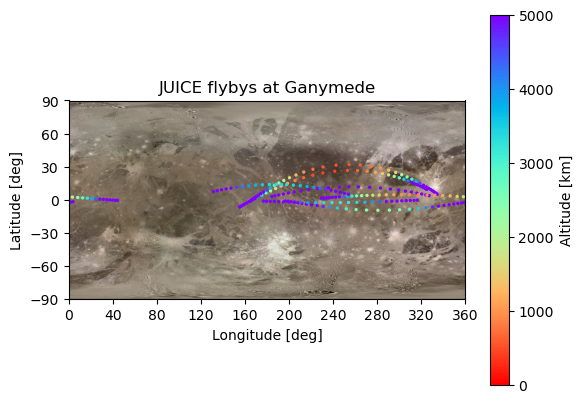

In [9]:
# Plot flybys
moon_map = flyby_moon.lower() + '_map.jpg'
img = plt.imread(moon_map)

fig, ax = plt.subplots()
ax.imshow(img, extent=[0, 360, -90, 90])
for k in range(number_of_flybys):
    dependent_variables = result2array(propagation_results[k].dependent_variable_history)

    # Resolve 2pi ambiguity for longitude
    for i in range(len(dependent_variables)):
        if dependent_variables[i, 2] < 0:
            dependent_variables[i, 2] = dependent_variables[i, 2] + 2.0 * np.pi

    plot = ax.scatter(dependent_variables[:, 2] * 180 / np.pi, dependent_variables[:, 1] * 180 / np.pi, s=2,
                      c=dependent_variables[:, 3] / 1e3, cmap='rainbow_r', vmin=0, vmax=5000)
cb = plt.colorbar(plot)

plt.xlabel('Longitude [deg]')
plt.ylabel('Latitude [deg]')
plt.xticks(np.arange(0, 361, 40))
plt.yticks(np.arange(-90, 91, 30))
cb.set_label('Altitude [km]')
plt.title('JUICE flybys at ' + flyby_moon)
plt.show()

## Time Step Evolution 

As we made use of a **variable time step** for our integration, it is instructive to check its **time evolution**.
The `propagation_results` list defined earlier is a list of [`SingleArcSimulationResults`](https://py.api.tudat.space/en/latest/propagation.html#tudatpy.numerical_simulation.propagation.SingleArcSimulationResults) objects (dictionaries) whose keys represent the computation time in seconds. **Taking the difference between the *(i)-th* and the *(i+1)-th* key will give the time step** used during the integration. Adding a vertical red line to the plot corresponding to each flyby's epoch, clearly highlights how **the time step value goes down around the epoch of closest approach with the moon**. 

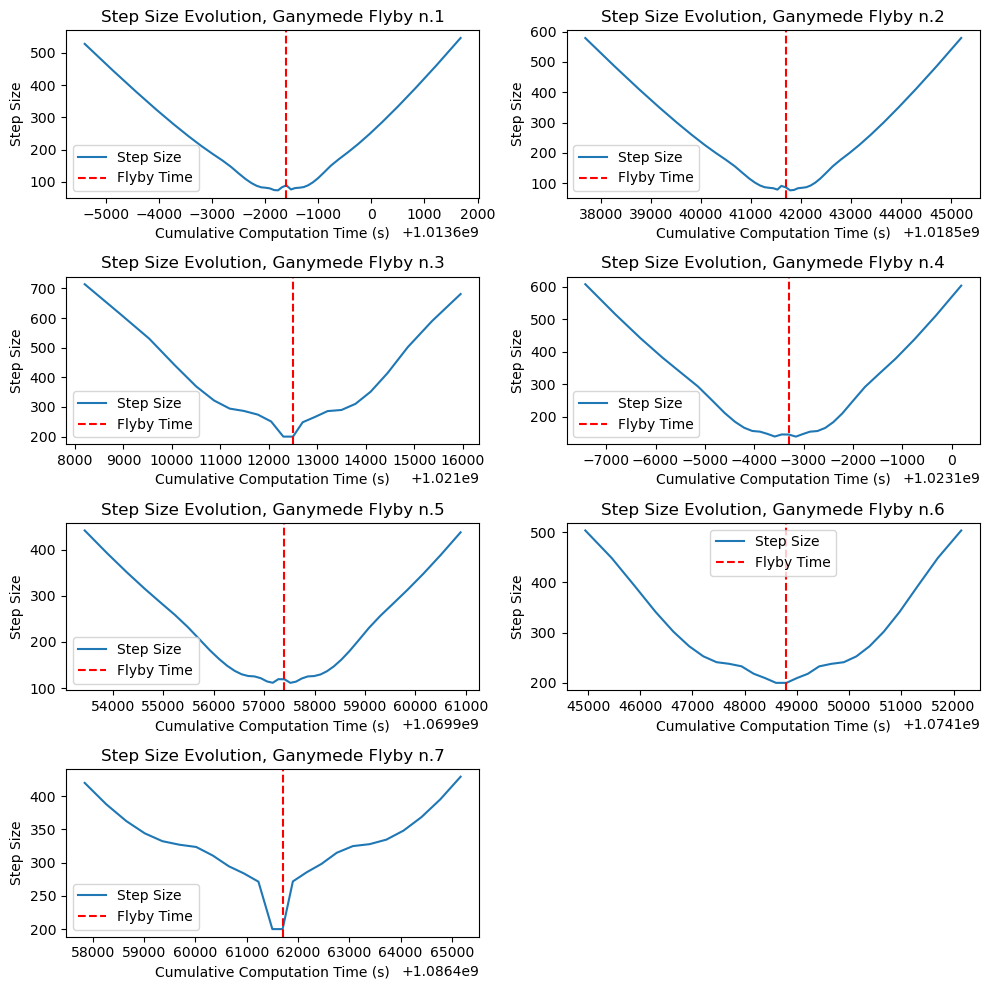

In [10]:
num_plots = len(propagation_results)
# Calculate the number of rows needed for two columns
num_rows = (num_plots + 1) // 2  # This ensures enough rows for odd numbers of plots
# Create a figure with subplots arranged in two columns
fig, axes = plt.subplots(num_rows, 2, figsize=(10, 10))
# Flatten axes array for easy indexing, in case num_plots is odd
axes = axes.flatten()

for i in range(num_plots):
    time_steps = np.diff(list(propagation_results[i].dependent_variable_history))
    times = list(propagation_results[i].dependent_variable_history)
    flyby_time = closest_approaches_juice[i]
    
    ax = axes[i]
    ax.plot(times[:-1], time_steps, label='Step Size')
    ax.axvline(flyby_time, color='r', linestyle='--', label='Flyby Time')
    ax.set_title(f"Step Size Evolution, {flyby_moon} Flyby n.{i+1}")
    ax.set_xlabel("Cumulative Computation Time (s)")
    ax.set_ylabel("Step Size")
    ax.legend()

# Hide any unused subplots if num_plots is odd
for j in range(num_plots, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout and show the figure with subplots
plt.tight_layout()
plt.show()